# Analisis de Sentimientos Moodle Deep Learning Modelo 3

# Librerias Necesarias

In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords') 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Importar Conjunto de Datos Consolidado

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

train = pd.read_csv('/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/dataset_balanced.csv', encoding='utf-8')


Mounted at /content/gdrive/


# Pre procesamiento

In [ ]:
train.head(15)

,text,sentiment
0,curso muy interesante en cuanto a contenido y en cuanto a desarrollo personal,POSITIVO
1,el mejor saludos desde panama,POSITIVO
2,es estupenda la manera en que te ensenan muy didactico y claro le doy un,POSITIVO
3,me ha parecido un curso fantastico breve didactico y muy bien preparado¡felicidadesfrancisco eugenio,POSITIVO
4,primera replica bueno creo que falta organizar la ideas pero al menos se miro el video de forma rapida en saltos como de cierta forma se responde con alguna ideas bastantes cambios que presenta ofrece distintas fases cambiante e incluso alterable teorias cientificas flexibles que se permiten adaptar etc lo que no comprendo son las siguientes frases investigaciones beneficiosas y lucrativas para el crecimiento de estas ciencias ciencia complejo ingenioso conocimiento para pasar de algo antiguo a algo innovador la ciencia trata de preguntar constantemente el porque de las cosas completamente redimidas esto es inedito en seguir buscando y este siga siendo persistente considero que ademas no se revisa lo que pide la pregunta que al plano de relatar lo presenta el conferencista tambien cosiste en relatar la experiencia personal de la cual no ha y nada en esta primera replica,POSITIVO
5,es muy claro que la pelicula es una recopilacion de hechos historicos en los cuales representan varios temas tratados en clase como la desviacion en la que un lider cambia su proposito o los medios manipulan la informacion para conveniencia se establece que la institucion es el estado que gobierna con unas leyes a conveniencia y lleva a un fanatismos con simbolizado con una imitacion por la esvastica utilizada por hitler por otro lado es un llamado a la revolucion necesaria asi conocida desde la revolucion francesa que se ha visto reflejada en muchas ocasiones con el fin de proteger una vez mas al pueblo oprimido y atacar el sistema que beneficia a unos cuantos en un punto de vista personal senti que esa pelicula solo cambio el contexto historico y llevo a las pantallas para demostrar el lema muy conocido el exceso del poder corrompe ya que aunque la idea de revolucion es necesaria no debe manejarse de esa forma,POSITIVO
6,excelente curso muy enriquecedor,POSITIVO
7,excelente curso todos los aplausos y felicitaciones para el docente excelente y explicito el material que nos brindo muy completo la verdad quedo mas que feliz y agradecida con el docente y la universidad,POSITIVO
8,excelente curso para aprender sobre el lenguaje de programacion python practico sencillo y muy bien estructurado,POSITIVO
9,excelente un verdadero manual de como usar el cerebro,POSITIVO


In [ ]:
#Longitud del dataset
len(train)
#Etiquetas de sentimiento
train['sentiment'].unique()
#Distribucion de dataset
train.groupby('sentiment').nunique()
#Valores Nulos
train["text"].isnull().sum()
train["text"].fillna("No content", inplace = True)

Funciones para limpieza de Texto

In [ ]:
#Funciones para limpiar el texto
#!pip install spacy
#!python -m spacy download es_core_news_sm

stop_words =stopwords.words('spanish')
stop_words.extend(['si', 'tambien', 'asi', 'debe', 'tener','cada','ademas','parte','ser','ma','mismo','mas'])  

#Funcion para remover tags html
def html_remover(data):
  beauti = BeautifulSoup(data,'html.parser')
  return beauti.get_text()

#Funcion para Remover URLs
def url_remover(data):
  return re.sub(r'https\S','',data)

def clean_text(text):
  #Convertir a minúsculas
  text = text.lower()
  #LLamar funciones para remover html y urls
  text= html_remover(text)
  text = url_remover(text) 
  #Eliminar texto entre corchetes, signos de puntuacion,numeros,espacios en blanco, emails
  text = re.sub('\[.*?¿\]\%', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub('[‘’“”…«»]', '', text)
  text = re.sub('\n','', text)
  text = re.sub('\S*@\S*\s?', '', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub("\'", "", text)

  text=text.strip()

  #Eliminar tildes y diacriticas
  text = re.sub('á', 'a', text)
  text = re.sub('é', 'e', text)
  text = re.sub('í', 'i', text)
  text = re.sub('ó', 'o', text)
  text = re.sub('ú', 'u', text)
  text = re.sub('ü', 'u', text)
  text = re.sub('ñ', 'n', text)
  text = re.sub('¿', '', text)
  text = re.sub('¡', '', text)
  text = re.sub('!', '', text)

  return text

#Funcion para convertir tokens en una oracion
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

#Tokenizar y remover stop words
def sent_to_words(sentences):
    for sentence in sentences:
        text=gensim.utils.simple_preprocess(str(sentence), deacc=True)
        text = [word for word in text if word not in stop_words]      
        yield(text)

Grabar los datos en una lista temporal para ejecutar funciones de limpieza de texto y tokenizar eliminando palabras vacias

In [ ]:
temp = []

data_to_list = train['text'].values.tolist()

for i in range(len(data_to_list)):
   temp.append(clean_text(data_to_list[i]))

data_words = list(sent_to_words(temp))


In [ ]:
print(data_words[:10])

[['curso', 'interesante', 'cuanto', 'contenido', 'cuanto', 'desarrollo', 'personal'], ['mejor', 'saludos', 'panama'], ['estupenda', 'manera', 'ensenan', 'didactico', 'claro', 'doy'], ['parecido', 'curso', 'fantastico', 'breve', 'didactico', 'bien', 'eugenio'], ['primera', 'replica', 'bueno', 'creo', 'falta', 'organizar', 'ideas', 'menos', 'miro', 'video', 'forma', 'rapida', 'saltos', 'cierta', 'forma', 'responde', 'alguna', 'ideas', 'bastantes', 'cambios', 'presenta', 'ofrece', 'distintas', 'fases', 'cambiante', 'incluso', 'alterable', 'teorias', 'cientificas', 'flexibles', 'permiten', 'adaptar', 'etc', 'comprendo', 'siguientes', 'frases', 'investigaciones', 'beneficiosas', 'lucrativas', 'crecimiento', 'ciencias', 'ciencia', 'complejo', 'ingenioso', 'conocimiento', 'pasar', 'antiguo', 'innovador', 'ciencia', 'trata', 'preguntar', 'constantemente', 'cosas', 'completamente', 'redimidas', 'inedito', 'seguir', 'buscando', 'siga', 'siendo', 'persistente', 'considero', 'revisa', 'pide', 'pre

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['curso interesante cuanto contenido cuanto desarrollo personal', 'mejor saludos panama', 'estupenda manera ensenan didactico claro doy', 'parecido curso fantastico breve didactico bien eugenio', 'primera replica bueno creo falta organizar ideas menos miro video forma rapida saltos cierta forma responde alguna ideas bastantes cambios presenta ofrece distintas fases cambiante incluso alterable teorias cientificas flexibles permiten adaptar etc comprendo siguientes frases investigaciones beneficiosas lucrativas crecimiento ciencias ciencia complejo ingenioso conocimiento pasar antiguo innovador ciencia trata preguntar constantemente cosas completamente redimidas inedito seguir buscando siga siendo persistente considero revisa pide pregunta plano relatar presenta conferencista cosiste relatar experiencia personal primera replica']


Convertir lista de textos en un array 

In [ ]:
data = np.array(data)
print(data)

['curso interesante cuanto contenido cuanto desarrollo personal'
 'mejor saludos panama' 'estupenda manera ensenan didactico claro doy' ...
 'nombre johny fernando licenciado trabajo docente colegio san fracisco javier expectativas frente seminario servir mejor'
 'acuerdo expuesto companero incumplimiento objeto obra contratista ver decisiones interventoria aprobar rechazar misma interventoria cumple papel consecuencias nefastas ejecucion obra tal mira proyecto mencion'
 'vida bien fisica mentalmente alcanzar metas propuesto diario vivir pasando situaciones ocasiones problematicas llevaderas segura desvio positivo quiero dar vida podre solucionar dejar lado felicidad homeostasis fisica mental buena hija hermana nieta amiga persona hacerlo siempre dado paz tranquilidad cierto modo sabiduria vida significa significaba naci simplemente mundo ahora vida empieza dar vuelco diferente imagine nina ahora cosas hago buenas malas repercuten vida ende vida rodean ello puedo decir proposito alcanz

Codificar las etiquetas

In [ ]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'NEUTRAL':
        y.append(0)
    if labels[i] == 'NEGATIVO':
        y.append(1)
    if labels[i] == 'POSITIVO':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

# Transformacion de datos a vectores para entrada a la red neuronal

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
import pickle
from keras.callbacks import ModelCheckpoint

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

import pickle

#Guardar tokenizador
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

[[   0    0    0 ...   78   20   62]
 [   0    0    0 ...    0   30 1435]
 [   0    0    0 ...  893  134 2729]
 ...
 [   0    0    0 ...  107 1358   30]
 [   0    0    0 ... 1930  135 2934]
 [   0    0    0 ...    7  162    4]]


In [ ]:
print(labels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


Dividir los datos para entrenamiento y test

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

7245 2415 7245 2415


# Modelado de la Red Neuronal

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 40)           200000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 123       
                                                                 
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________


#Entrenamiento del modelo

In [ ]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
227/227 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.5329
Epoch 1: val_accuracy improved from -inf to 0.63271, saving model to best_model2.hdf5
227/227 [==============================] - 36s 138ms/step - loss: 0.9451 - accuracy: 0.5329 - val_loss: 0.8303 - val_accuracy: 0.6327
Epoch 2/70
227/227 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.6690
Epoch 2: val_accuracy improved from 0.63271 to 0.68489, saving model to best_model2.hdf5
227/227 [==============================] - 30s 132ms/step - loss: 0.7619 - accuracy: 0.6690 - val_loss: 0.7350 - val_accuracy: 0.6849
Epoch 3/70
227/227 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.7244
Epoch 3: val_accuracy improved from 0.68489 to 0.72215, saving model to best_model2.hdf5
227/227 [==============================] - 30s 133ms/step - loss: 0.6702 - accuracy: 0.7244 - val_loss: 0.6622 - val_accuracy: 0.7222
Epoch 4/70
227/227 [==========================

#Evaluar al modelo

In [ ]:
best_model = keras.models.load_model("best_model2.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

76/76 - 3s - loss: 0.8369 - accuracy: 0.8095 - 3s/epoch - 33ms/step
Model accuracy:  0.8095238208770752


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


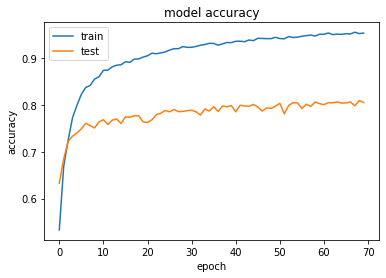

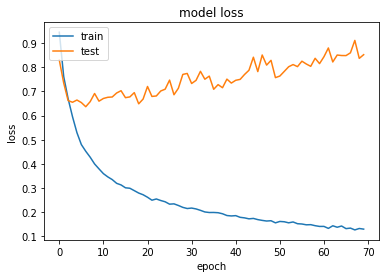

In [ ]:
print(history.history.keys())
# history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import time
import numpy as np

predictions = best_model.predict(X_test)
start_time = time.time()
test_predictions = np.argmax(best_model.predict(X_test), axis=-1)
print(classification_report(y_test.argmax(axis=1),test_predictions))
print("Time taken to predict the model " + str(time.time() - start_time))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       830
           1       0.77      0.81      0.79       781
           2       0.85      0.84      0.84       804

    accuracy                           0.81      2415
   macro avg       0.81      0.81      0.81      2415
weighted avg       0.81      0.81      0.81      2415

Time taken to predict the model 1.6576547622680664


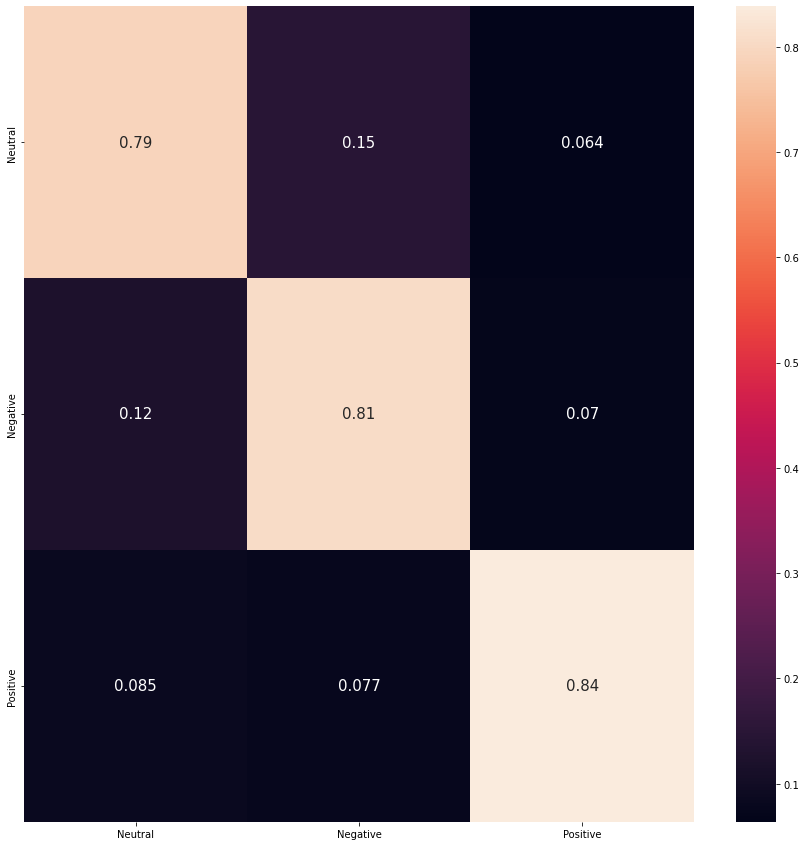

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})